In [ ]:
# # Continual Learning on Medical MNIST (ResNet50 + Replay Buffer + Knowledge Distillation)
#
# This notebook performs continual learning on the Medical MNIST dataset.
# It mirrors the CIFAR-10 incremental learning setup:
# - Uses a pretrained ResNet50 backbone
# - Splits dataset into multiple incremental tasks
# - Uses a replay buffer for past samples
# - Applies knowledge distillation between teacher and student models

# %%
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import kagglehub

# %%
# Step 1: Download dataset
path = kagglehub.dataset_download("andrewmvd/medical-mnist")
print("Dataset path:", path)


2025-10-29 22:42:58.585100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: /home/rameyjm7/.cache/kagglehub/datasets/andrewmvd/medical-mnist/versions/1


Found 47164 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.
Detected classes: {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


I0000 00:00:1761792198.739141 1430152 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Epoch 1/10


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-29 22:43:25.209918: I external/local_xla/xla/service/service.cc:163] XLA service 0x155330004300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-29 22:43:25.209940: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-10-29 22:43:25.345336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-29 22:43:26.525627: I external/local_xla/xla/stream_executor/cuda/cuda

1474/1474 - 75s - 51ms/step - accuracy: 0.7381 - loss: 0.8734 - val_accuracy: 0.9031 - val_loss: 0.4238
Epoch 2/10
1474/1474 - 36s - 25ms/step - accuracy: 0.9093 - loss: 0.3446 - val_accuracy: 0.9235 - val_loss: 0.2464
Epoch 3/10
1474/1474 - 36s - 24ms/step - accuracy: 0.9307 - loss: 0.2329 - val_accuracy: 0.9299 - val_loss: 0.1958
Epoch 4/10
1474/1474 - 36s - 24ms/step - accuracy: 0.9410 - loss: 0.1838 - val_accuracy: 0.9458 - val_loss: 0.1572
Epoch 5/10
1474/1474 - 36s - 24ms/step - accuracy: 0.9483 - loss: 0.1552 - val_accuracy: 0.9472 - val_loss: 0.1410
Epoch 6/10
1474/1474 - 36s - 25ms/step - accuracy: 0.9538 - loss: 0.1358 - val_accuracy: 0.9574 - val_loss: 0.1229
Epoch 7/10
1474/1474 - 36s - 24ms/step - accuracy: 0.9606 - loss: 0.1194 - val_accuracy: 0.9627 - val_loss: 0.1110
Epoch 8/10
1474/1474 - 36s - 25ms/step - accuracy: 0.9630 - loss: 0.1093 - val_accuracy: 0.9559 - val_loss: 0.1148
Epoch 9/10
1474/1474 - 36s - 25ms/step - accuracy: 0.9668 - loss: 0.0995 - val_accuracy: 0.

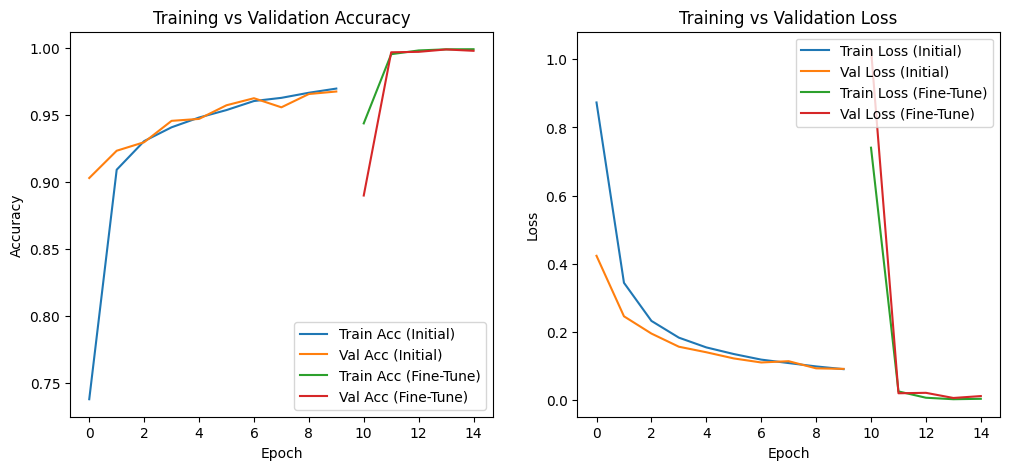

Fine-tuned model saved as medical_mnist_resnet50_finetuned.keras
==== Summary ====
Validation Accuracy before Fine-Tuning: 0.9677
Validation Accuracy after Fine-Tuning:  0.9980


In [ ]:
# Step 2: Define paths and parameters
dataset_dir = path
img_size = (64, 64)
batch_size = 32
base_learning_rate = 1e-4
fine_tune_learning_rate = 1e-5
initial_epochs = 10
fine_tune_epochs = 5

# Step 3: Prepare data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Detected classes:", train_gen.class_indices)

# Step 4: Build model based on pretrained ResNet50
def create_resnet_model(num_classes, train_base=False):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(*img_size, 3)
    )
    base_model.trainable = train_base  # Freeze or unfreeze base
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=base_learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Step 5: Initial training (frozen ResNet layers)
model = create_resnet_model(num_classes, train_base=False)
history_initial = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs,
    verbose=2
)

# Step 6: Evaluate initial training
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy before Fine-Tuning: {val_acc:.4f}")

# Step 7: Fine-tuning (unfreeze entire ResNet)
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=fine_tune_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    verbose=2
)

# Step 8: Evaluate post-fine-tuning
val_loss_ft, val_acc_ft = model.evaluate(val_gen)
print(f"Validation Accuracy after Fine-Tuning: {val_acc_ft:.4f}")

# Step 9: Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['accuracy'], label='Train Acc (Initial)')
plt.plot(history_initial.history['val_accuracy'], label='Val Acc (Initial)')
plt.plot(np.arange(len(history_initial.history['accuracy']),
                   len(history_initial.history['accuracy']) + len(history_finetune.history['accuracy'])),
         history_finetune.history['accuracy'], label='Train Acc (Fine-Tune)')
plt.plot(np.arange(len(history_initial.history['val_accuracy']),
                   len(history_initial.history['val_accuracy']) + len(history_finetune.history['val_accuracy'])),
         history_finetune.history['val_accuracy'], label='Val Acc (Fine-Tune)')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_initial.history['loss'], label='Train Loss (Initial)')
plt.plot(history_initial.history['val_loss'], label='Val Loss (Initial)')
plt.plot(np.arange(len(history_initial.history['loss']),
                   len(history_initial.history['loss']) + len(history_finetune.history['loss'])),
         history_finetune.history['loss'], label='Train Loss (Fine-Tune)')
plt.plot(np.arange(len(history_initial.history['val_loss']),
                   len(history_initial.history['val_loss']) + len(history_finetune.history['val_loss'])),
         history_finetune.history['val_loss'], label='Val Loss (Fine-Tune)')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Step 10: Save final fine-tuned model
model.save("medical_mnist_resnet50_finetuned.keras")
print("Fine-tuned model saved as medical_mnist_resnet50_finetuned.keras")

# Summary
print("==== Summary ====")
print(f"Validation Accuracy before Fine-Tuning: {val_acc:.4f}")
print(f"Validation Accuracy after Fine-Tuning:  {val_acc_ft:.4f}")
